<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


In [ ]:
!pip install contextily

In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
# Import CCD from google drive Source: Census
ccd_name = "/content/drive/My Drive/FreightProfiles/tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(ccd_name)
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "/content/drive/MyDrive/FreightProfiles/Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(rail_name)

In [83]:
rail.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

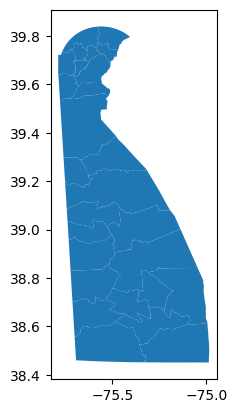

In [213]:
ccd.plot()

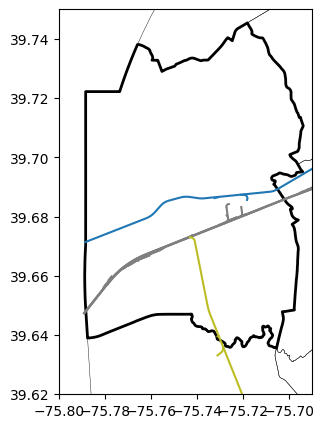

In [85]:
fig, ax = plt.subplots(figsize =(5,5))

ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]=="Newark"].plot(facecolor = "none", lw = 2 , ax=ax)
#rail.to_crs(ccd.crs).plot("OWNER", legend=True,  ax=ax)
rail.to_crs(ccd.crs).plot("OWNER",   ax=ax)

ax.set_xlim(-75.8, -75.69)
ax.set_ylim(39.62, 39.75)

fig.show()



In [176]:
ccd.NAME

0                           Lewes
1                       Millsboro
2                    Central Kent
3                          Smyrna
4               Middletown-Odessa
5                      New Castle
6     Pike Creek-Central Kirkwood
7                      Wilmington
8                Lower Christiana
9                        Piedmont
10               Upper Christiana
11                     Georgetown
12                  Milford South
13                        Seaford
14           Selbyville-Frankford
15                  Laurel-Delmar
16                         Milton
17          Bridgeville-Greenwood
18                          Dover
19                         Kenton
20                         Felton
21                  Milford North
22                     Harrington
23                     Brandywine
24                        Glasgow
25                       Red Lion
26                         Newark
Name: NAME, dtype: object

In [86]:
ccd = ccd.to_crs(rail.crs)

# Get the intersection of the line and the polygon
intersection = gpd.overlay(rail, ccd[ccd["NAME"]=="Newark"], how="intersection")


# Get the length of the intersection
intersection.length.sum()

# Print the result
#print(f"The length of the line within the polygon is {length:.2f} units.")

87928.69994266432

                                 SHAPELEN  length_meters  length_miles
OWNER                                                                 
Norfolk Southern Corporation  56135.53635   4.844050e+06   3009.952402


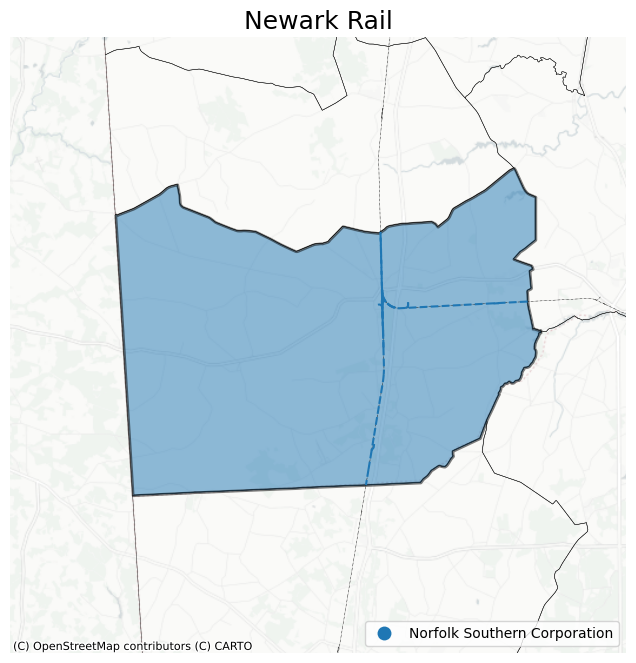

In [208]:
import contextily as cx

CCD = "Harrington"
resol = 20000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

fig, ax = plt.subplots(figsize=(8,8))

plt.title("Newark Rail", fontdict={"fontsize":18})

ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
rail.to_crs(ccd.crs).plot(color="k", linestyle="-.", lw = 0.3, ax=ax)
ccd = ccd.to_crs(rail.crs)
gpd.overlay(rail, ccd[ccd["NAME"]==CCD],
            how="intersection").plot("OWNER",
                                     linestyle="--", ax=ax,
                                     legend=True,
                                     legend_kwds={'loc':"lower right"})

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)
fig.show()

ccd = ccd.to_crs(rail.crs)
ccd["length_meters"] = ccd.length
ccd["length_miles"] = ccd.length_meters * 0.000621371
print(gpd.overlay(rail, ccd[ccd["NAME"]== CCD], how="intersection").groupby("OWNER").sum(numeric_only = True)[["SHAPELEN","length_meters", "length_miles"]])